In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
urllib3.disable_warnings()
import seaborn as sns
import palettable

plt.rcParams['figure.facecolor']='w'

In [2]:
df_all=pd.DataFrame()
for i in np.arange(1,9):
    season_num=str(i)
    site_ = "https://www.imdb.com/title/tt0944947/episodes?season="+season_num
    http = urllib3.PoolManager()
    r = http.request('GET', site_)

    soup = BeautifulSoup(r.data, 'html.parser')
    spans = soup.find_all('span', {'class' : 'ipl-rating-star__rating'})
    
    lines = [span.get_text() for span in spans]
    
    df_season=pd.DataFrame(pd.to_numeric(lines,errors='coerce'))
    df_season=df_season.dropna()
    df_season=df_season.iloc[::12]
    df_season=df_season.reset_index(drop=True)
    
    df_season.loc[:,'Season']=season_num
    df_season.loc[:,'EpisodeNum']=df_season.index+1
    
    df_season.columns=['Rating','Season','Episode Number']
    
    df_all=pd.concat([df_all,df_season])

Text(0.5, 1.0, 'Game of Throne IMDB Ratings\n')

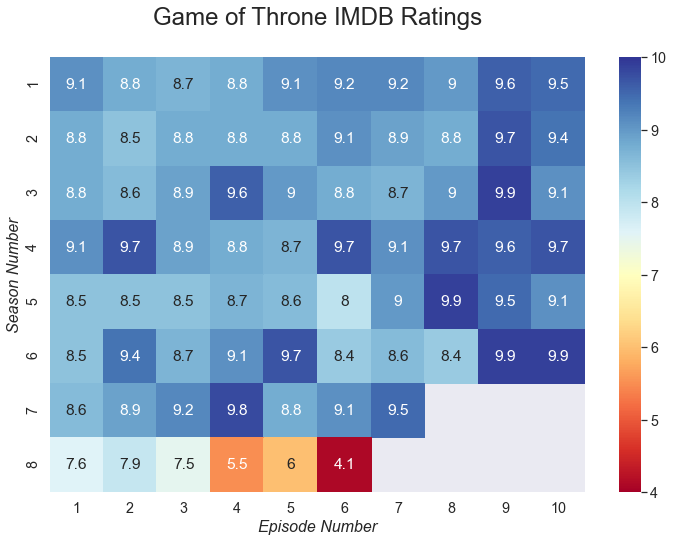

In [3]:
#cmap=palettable.cubehelix.cubehelix1_16.get_mpl_colormap()
cmap=palettable.colorbrewer.diverging.RdYlBu_11.get_mpl_colormap()
sns.set(font_scale = 1.3)

df_pivot=df_all.pivot(index='Season',columns='Episode Number')
df_pivot.columns=np.arange(1,11)

fig,ax=plt.subplots(figsize=(12,8))

sns.heatmap(df_pivot,annot=True,cmap=cmap,vmin=4,vmax=10)

ax.set_xlabel('Episode Number',fontsize=16,style='italic')
ax.set_ylabel('Season Number',fontsize=16,style='italic')
ax.set_title('Game of Throne IMDB Ratings\n',fontsize=24)

In [5]:
import types
requirements=[]
for name,val in globals().items():
    if isinstance(val, types.ModuleType):       
        #print (name,val)
        name = val.__name__.split(".")[0]
        requirements.append(name)
#print(requirements)

In [6]:
import pkg_resources
pkgs_=[]
for val in pkg_resources.working_set:
    pkgname=str(val).split(' ')[0]
    pkgversion=str(val).split(' ')[1]
    if pkgname in requirements:
        pkgs_.append(pkgname+'=='+pkgversion)

In [7]:
pkgs_

['urllib3==1.24.1',
 'seaborn==0.10.0',
 'pandas==1.0.3',
 'palettable==3.1.0',
 'numpy==1.18.2',
 'matplotlib==3.2.1']